# Data and Package Import

## W207 House Price Prediction - Baseline Submission
### Group - Clayton Leach, Mark H, Rohini Kashibatla

In [1]:
from datetime import date
import warnings

import numpy as np
import pandas as pd
import scipy
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import sklearn.neural_network as neural_network


import matplotlib.pyplot as plt
import scipy.stats as norm
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost

warnings.filterwarnings('ignore')

# Make it easy to see our different features within Jupyter
pd.set_option('display.max_columns', 500)

# Import our test and training datasets from local source
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

# Set our labels equal to Sale Price and remove this column from training dataset
train_labels = train_df['SalePrice']


## Summary

Based on the correlation matrix with top 10 features, we choose 6 features as explanatory variables in linear regression. This baseline model with K-folder validation gives us a sense of the goodness-of-fit on training data and model prediction error on test data.

# EDA

# Target

What does the distribution of our target variable SalePrice look like before and after Log transform

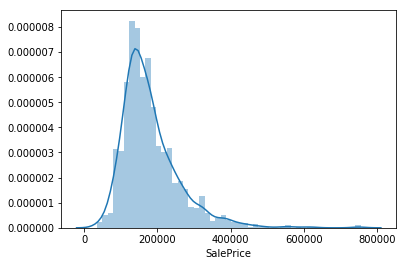

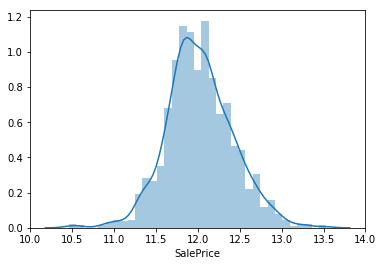

In [2]:
sns.distplot(train_df['SalePrice'])
fig = plt.figure()
sns.distplot(np.log(train_df['SalePrice']))

# Visualizing Some Categorical Variables

Understanding how categorical variable affect the distribution of SalePrice

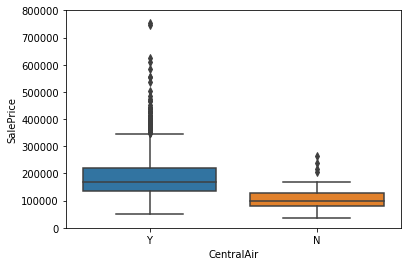

In [3]:
# CentralAir
var = 'CentralAir'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

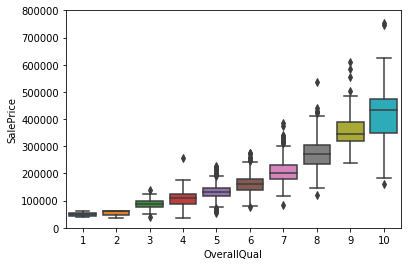

In [4]:
# OverallQual
var = 'OverallQual'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

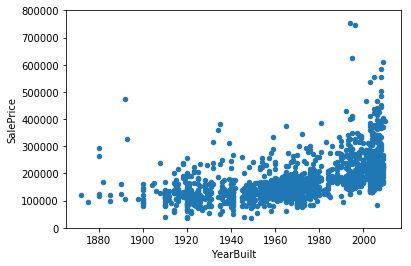

In [5]:
# YearBuilt  scatter
var = 'YearBuilt'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
data.plot.scatter(x=var, y="SalePrice", ylim=(0, 800000))

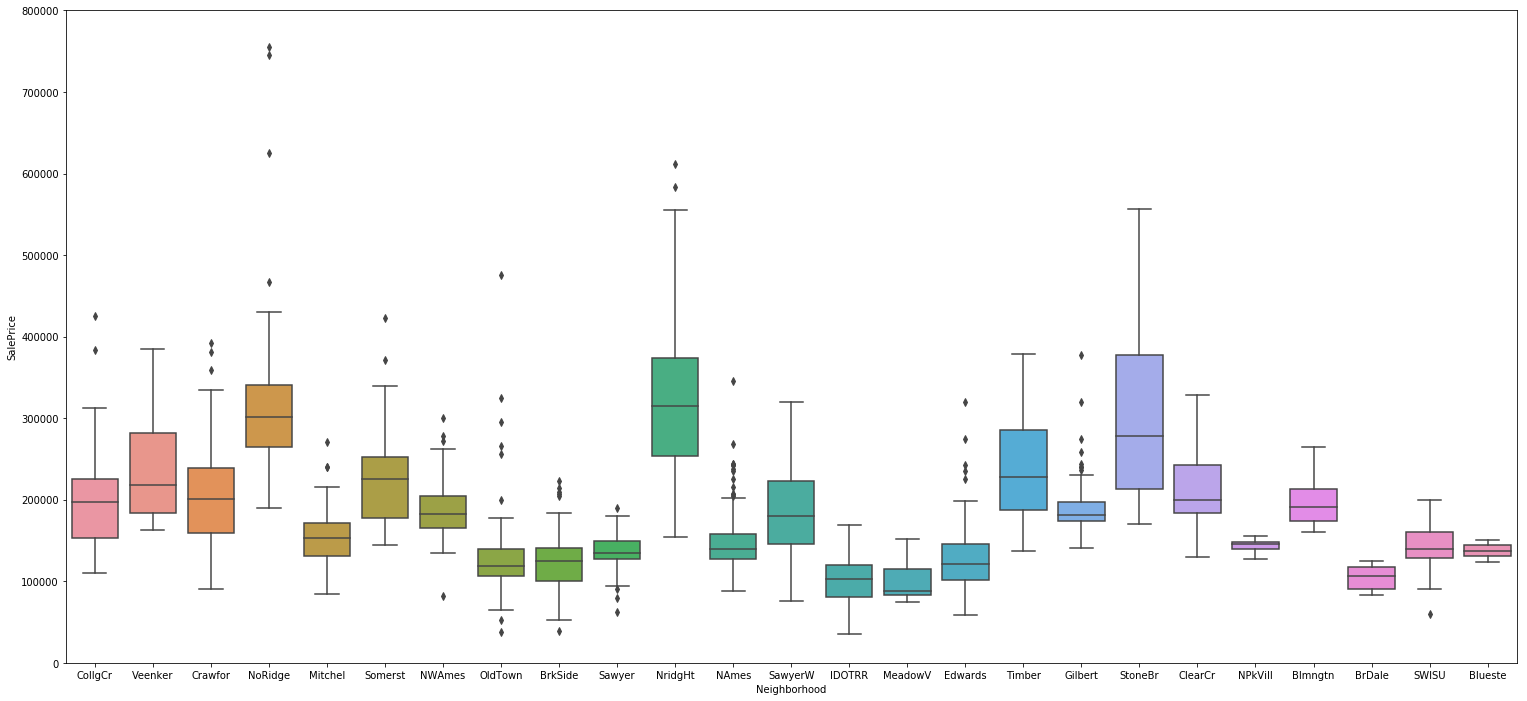

In [6]:
# Neighborhood
var = 'Neighborhood'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(26, 12))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

# Numerical Varibales  

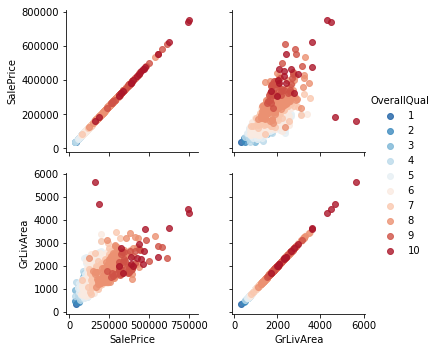

In [7]:
g = sns.PairGrid(train_df, vars=['SalePrice', 'GrLivArea'],
                 hue='OverallQual', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

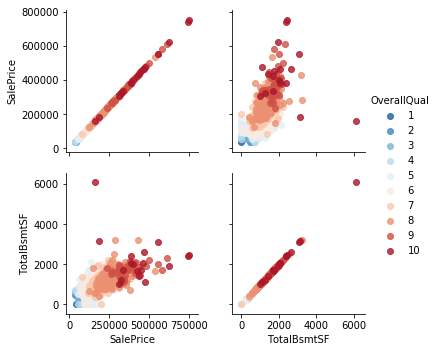

In [8]:
g = sns.PairGrid(train_df, vars=['SalePrice', 'TotalBsmtSF'],
                 hue='OverallQual', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

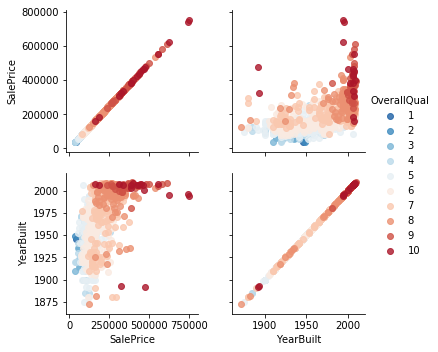

In [9]:
g = sns.PairGrid(train_df, vars=['SalePrice', 'YearBuilt'],
                 hue='OverallQual', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

# PreProcessing

Data cleaning, feature extraction, and scaling

In [10]:
def convert_categorical_to_dummy(df, columns = [], drop_first = False, dummy_na = True):
    """
    Convert all categorical variables to k dummy variables.  Include NaNs as a column as this indicates
    the absense of a feature and might be useful in non-linear models
    """
    if len(columns) > 0:
        new_df = pd.get_dummies(df, drop_first = drop_first, columns = columns, dummy_na=dummy_na)
    else:
        new_df = pd.get_dummies(df, drop_first = drop_frist, dummy_na=dummy_na)
        
    return new_df
        

In [11]:
def recession_indicator(row):
    """Take in sale date and return whether it was during recession
    as determined by official statistics; only include the recession
    which occured during years in question, but can expand as necessary
    https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States"""
    
    period = date(row['YrSold'],row['MoSold'],1)
    if (period >= date(2007,12,1)) & (period <= date(2009,6,1)) :
        return 'recession'
    else:
        return ''

In [12]:
# Convert year based features to age; Most recent year is 2010, so we will treat that as year 0
def convert_year_to_age(row, columns):
    """Helper function to convert year features into age from sale date"""
    for col in columns:
        row[col] = row['YrSold']-row[col]
    return row

In [13]:
def random_data_cleaning(df):

   # VnrType has None to indicate None but also NaNs.  Convert None to NaN to treat them identically
    df['MasVnrType'] = df['MasVnrType'].apply(lambda x: np.nan if x == 'None' else x)

   # Vnr Area is NaN when there is no Vnr.  Therefore, this is identical to setting to 0
    df['MasVnrArea'] = df['MasVnrArea'].apply(lambda x: 0 if np.isnan(x) else x )

   # Assume NaN indicates there is no street connected to property, therefore 0 feet
    df['LotFrontage'] = df['LotFrontage'].apply(lambda x: 0 if np.isnan(x) else x)

   # Convert Garage Year Built to categorical (Picked 1990 arbitrarily)
    df['GarageYrBlt'] = df['GarageYrBlt'].apply(lambda x: 'old' if x < 1990 else ('new' if
                                              x >1990 else 'no garage'))
   # Assume NaN indicates that house does not have object feature refers to.  Since it is a numeric
   # feature we set it to 0. (E.g. not having a basement is identical to having a basement of 0 sqft)
    df['MasVnrArea'] = df['MasVnrArea'].apply(lambda x: 0 if np.isnan(x) else x )
    df['LotFrontage'] = df['LotFrontage'].apply(lambda x: 0 if np.isnan(x) else x)
    df['BsmtFinSF1'] = df['BsmtFinSF1'].apply(lambda x: 0 if np.isnan(x) else x)
    df['BsmtFinSF2'] = df['BsmtFinSF2'].apply(lambda x: 0 if np.isnan(x) else x)
    df['BsmtUnfSF'] = df['BsmtUnfSF'].apply(lambda x: 0 if np.isnan(x) else x)
    df['TotalBsmtSF'] = df['TotalBsmtSF'].apply(lambda x: 0 if np.isnan(x) else x)
    df['BsmtFullBath'] = df['BsmtFullBath'].apply(lambda x: 0 if np.isnan(x) else x)
    df['BsmtHalfBath'] = df['BsmtHalfBath'].apply(lambda x: 0 if np.isnan(x) else x)
    df['GarageCars'] = df['GarageCars'].apply(lambda x: 0 if np.isnan(x) else x)
    df['GarageArea'] = df['GarageArea'].apply(lambda x: 0 if np.isnan(x) else x)

    return df

In [14]:
train_df['recession'] = train_df.apply(lambda x: recession_indicator(x), axis = 1)
test_df['recession'] = test_df.apply(lambda x: recession_indicator(x), axis = 1)

In [15]:
train_df = random_data_cleaning(train_df)
test_df = random_data_cleaning(test_df)

In [16]:
"""Note: Garage Year Built can't be converted to age as not every property has a garage"""

year_cols = ['YearBuilt','YearRemodAdd',]
new_train = train_df.apply(convert_year_to_age, args=(year_cols,), axis=1)
new_test = test_df.apply(convert_year_to_age, args=(year_cols,), axis=1)


In [17]:
# List of columns which we believe it makes sense to convert to boolean. 


categorical_columns = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig',
                       'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle',
                       'RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation',
                       'BsmtQual','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional',
                       'GarageType','PavedDrive','PoolQC','Fence','MiscFeature','MoSold','SaleType',
                       'SaleCondition','recession','YrSold']

"""Need to separate these out so we can specify not to include a column for NaNs.  We do this because we 
will have already created this column.  For Basement, if there is no basement we will create the no basement
column by splitting "BsmtQual", and for Garage we will do so by splitting "GarageType".  This would naturally
be resolved in PCA as they would be perfectly correlated, but we opt to resolve this prior to PCA."""

categorical_columns_no_nan = ['BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageFinish',
                       'GarageQual','GarageCond','GarageYrBlt','FireplaceQu',]

new_train = convert_categorical_to_dummy(new_train,categorical_columns)
new_test = convert_categorical_to_dummy(new_test,categorical_columns)

new_train = convert_categorical_to_dummy(new_train,categorical_columns_no_nan, dummy_na=False)
new_test = convert_categorical_to_dummy(new_test,categorical_columns_no_nan, dummy_na=False)

#Use to cluster neighborhoods later
neighborhoods = [col for col in new_train.columns if "Neighborhood" in col]+['GrLivArea', 'SalePrice']
neighborhood_df = new_train[neighborhoods]

styles = [col for col in new_train.columns if "HouseStyle" in col]+['GrLivArea', 'SalePrice']
styles_df = new_train[styles]


# Remove SalePrice from training set as it is our target variable
new_train = new_train.drop(['SalePrice'], axis=1)

In [18]:
# Get missing columns in the training test
missing_cols = set( new_train.columns ) - set( new_test.columns )

# Add a missing column in test set with default value equal to 0
for col in missing_cols:
    new_test[col] = 0
    
# Ensure matching order and columns between train and test sets
new_test = new_test[new_train.columns]

In [19]:
# Check to make sure that our missing columns are only derived from the test data lacking specific instances
# of a categorical variable.  
for col in missing_cols:
    if (col.split("_")[0] not in categorical_columns) &(col.split("_")[0] not in categorical_columns_no_nan):
        print("Error, %s was not derived from a missing category" %col)

In [20]:
# Use SKLearn scaling 
def min_max_scaling(df, columns):
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled_df = min_max_scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_df,columns = columns)
    return scaled_df, min_max_scaler

# Opt for min-max scaling as opposed to mean normalization as we have so many boolean variables.  Min-Max
# preserve the 0/1 nature of these features.  We may revisit using alternative scaling methods in future
# iterations of preprocessing

scaled_train, min_max_scaler_train = min_max_scaling(new_train, new_train.columns)
#scaled_train['Id'] = scaled_train.index + 1

scaled_test = pd.DataFrame(min_max_scaler_train.transform(new_test),columns=new_test.columns)
#scaled_test['Id'] = scaled_test.index + 1

In [21]:
# Confirm none of our columns contain NaN values
scaled_train.columns[scaled_train.isna().any()].tolist()

[]

# Baseline

In [22]:
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)


## Correlation Matrix
Top 10 most correlated features to SalePrice

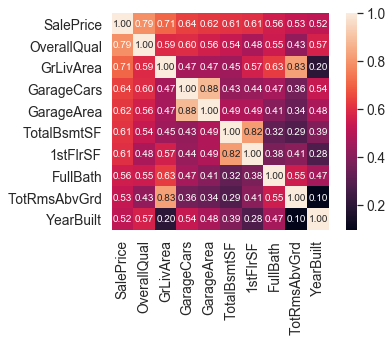

In [23]:
corrmat = train_df.corr()
k = 10
cols = corrmat.nlargest(k,'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [24]:
print(cols)
#g = sns.pairplot(scaled_train[cols])

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')


In [25]:
cols = ['OverallQual','GrLivArea', 'GarageCars','TotalBsmtSF','TotRmsAbvGrd', 'YearBuilt']
x = scaled_train[cols].values
y = train_labels.values
y_log = np.log(y.reshape(-1,1))

In [26]:
# Do K-folds to create train/test splits
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [27]:
for train, test in kf.split(x):
    # Use index to create train and test data and labels
    train_data, train_label, test_data, test_label = x[train], y_log[train], x[test], y_log[test]
    
    # Create instance of LinearRegression object from SKLearn
    model = linear_model.LinearRegression()
    model.fit(train_data,train_label)
    print("The R^2 for this run is: %s" %model.score(train_data,train_label))
    
   
    y_pred = model.predict(test_data)
    print("The Root Mean Squared Error for this run is: %s" %rmse(test_label,y_pred))

The R^2 for this run is: 0.8017927803942895
The Root Mean Squared Error for this run is: [0.16411907]
The R^2 for this run is: 0.8342677558662451
The Root Mean Squared Error for this run is: [0.22263131]
The R^2 for this run is: 0.8096564009441117
The Root Mean Squared Error for this run is: [0.16500317]
The R^2 for this run is: 0.814807117401844
The Root Mean Squared Error for this run is: [0.17247055]
The R^2 for this run is: 0.804872177212174
The Root Mean Squared Error for this run is: [0.15409332]


In [28]:
cols = ['OverallQual','GrLivArea', 'GarageCars','TotalBsmtSF','TotRmsAbvGrd', 'YearBuilt']
x = scaled_train[cols].values
y = train_labels.values
y_log = np.log(y.reshape(-1,1))
model = linear_model.LinearRegression()
model.fit(x,y_log)
x_test = scaled_test[cols].values
predictions = model.predict(x_test)
predictions = np.exp(predictions)


In [29]:
test_df['Id']
submission = pd.DataFrame({'Id':test_df['Id']})
submission['SalePrice'] = np.round(predictions,2)
submission.head()
filename = 'submission.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: submission.csv


Kaggle Submission
Made with userid - testrk
3195 new testrk testrk 0.16667

Your Best Entry 
Your submission scored 0.16667, which is not an improvement of your best score. Keep trying!





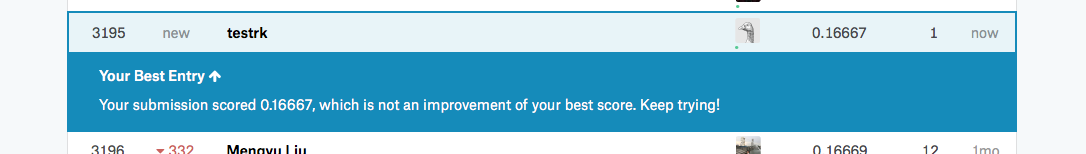

In [30]:
from IPython.display import Image
Image(filename='kaggle_submit.png') 

## Support Vector Regression

In [31]:
# SVR 
def model_svr():
    
    from sklearn.svm import SVR
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    svr_lin = SVR(kernel='linear', C=1e3)
    svr_poly = SVR(kernel='poly', C=1e3, degree=3)
    y_rbf = svr_rbf.fit(x, y).predict(x_test)
    y_lin = svr_lin.fit(x, y).predict(x_test)
    y_poly = svr_poly.fit(x, y).predict(x_test)

    # Do K-folds to create train/test splits
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    for train, test in kf.split(x):
        # Use index to create train and test data and labels
        train_data, train_label, test_data, test_label = x[train], y_log[train], x[test], y_log[test]

        svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
        svr_rbf.fit(train_data,train_label)
        print("svr_rbf The R^2 for this run is: %s" %svr_rbf.score(train_data,train_label))

        #svr_lin = SVR(kernel='linear', C=1e3)
        svr_lin = SVR(kernel='linear', C=1000)
        svr_lin.fit(train_data,train_label)
        print("svr_lin The R^2 for this run is: %s" %svr_lin.score(train_data,train_label))

        svr_poly = SVR(kernel='poly', C=1e3, degree=3)
        svr_poly.fit(train_data,train_label)
        print("svr_poly The R^2 for this run is: %s" %svr_poly.score(train_data,train_label))


        y_pred = svr_rbf.predict(test_data)
        r = rmse(test_label,y_pred)
        #print(r)
        #print("The Root Mean Squared Error for this run is: %s" %rmse(test_label,y_pred))



    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import classification_report

    # Set the parameters by cross-validation
    parameters = [{'kernel': ['rbf'],
                   'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
                    'C': [1, 10, 100, 1000,1e3]},
                  {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

    print("# Tuning hyper-parameters")
    print()

    model = GridSearchCV(SVR(kernel='rbf'), parameters, cv=5)
    model.fit(x, y)

    print("Best parameters set found on development set:")
    print()
    print(model.best_params_)
    print()
    print("Grid scores on training set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    cols = ['OverallQual','GrLivArea', 'GarageCars','TotalBsmtSF','TotRmsAbvGrd', 'YearBuilt']
    x = scaled_train[cols].values
    y = train_labels.values
    y_log = np.log(y.reshape(-1,1))

    #svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    #svr_rbf = SVR(kernel='rbf', C=1000000.0, gamma=0.5,epsilon=0.25)
    svr_rbf = model
    svr_rbf.fit(train_data,train_label)
    svr_rbf.fit(x,y_log)
    x_test = scaled_test[cols].values
    predictions = svr_rbf.predict(x_test)

    predictions = np.exp(predictions)

    test_df['Id']
    submission = pd.DataFrame({'Id':test_df['Id']})
    submission['SalePrice'] = np.round(predictions,2)
    submission.head()
    filename = 'submission_svr.csv'
    submission.to_csv(filename,index=False)
    print('Saved file: ' + filename)




Modeling to do list:

    1) Do all of the below both pre and post PCA (Mark wants to write PCA function)

    2) Do all of the below both pre and post k-means++ clustering

Models:

    1) Neural net (Feed Forward)

    2) XGBoost (or RF) (Clay)

    3) GMM

    4) SVM (Rohini)

    5) KNN (Restrict what features we use)
    
    6) Elastic Net (Mark)



In [32]:
# PCA + GXBoost = Best | Clay & Rohini prediction
# Lasso Regression     | Mark predicts this will be the hard to beat

## XGBOOST

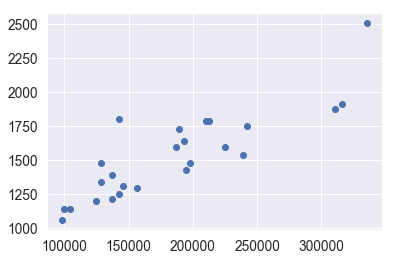

In [33]:
# See if there is a way to collapse neighborhoods
nhoods = [col for col in new_train.columns if "Neighborhood" in col]
neighborhood_agg = neighborhood_df.groupby(nhoods).agg({"SalePrice":"mean","GrLivArea":"mean" }).reset_index()
x=neighborhood_agg["SalePrice"]
y=neighborhood_agg["GrLivArea"]
plt.scatter(x,y)

From the above we can see there are two neighborhoods which don't fit the general linear trend between
sqft and price.  We will only include these two neighborhoods, as they should be the only neighborhood
variables which convey additional information

    Neighborhood_SWISU : Significantly more SQft for price relative to other neighborhoods
    Neighborhood_NoRidge : Very expensive, but significantly more SQft than pattern observed elsewhere

In [34]:
# Turns out its very important to keep these two neighborhoods, but also there is value in keeping the rest
# kept_nhoods = ["Neighborhood_SWISU", "Neighborhood_NoRidge"]
# dropped_nhoods = [nhood for nhood in nhoods if nhood not in kept_nhoods]
# df = new_train.drop(dropped_nhoods, axis = 1)
# df_test = new_test.drop(dropped_nhoods, axis = 1)

In [35]:
df = new_train
df_test=new_test

In [36]:
# No reason not to combine these values into single feature
df["baths"] = df["FullBath"]+.5*df["HalfBath"]
df = df.drop(['FullBath','HalfBath'], axis = 1)

df_test["baths"] = df_test["FullBath"]+.5*df_test["HalfBath"]
df_test = df_test.drop(['FullBath','HalfBath'], axis = 1)

In [37]:
df['BasmtBaths'] = df['BsmtFullBath'] + .5*df['BsmtHalfBath']
df = df.drop(['BsmtFullBath','BsmtHalfBath'], axis = 1)

df_test['BasmtBaths'] = df_test['BsmtFullBath'] + .5*df_test['BsmtHalfBath']
df_test = df_test.drop(['BsmtFullBath','BsmtHalfBath'], axis = 1)

In [38]:
# Very rarely do these deviate significantly; GrLivArea captures total SqFt, and 1story captures number of stories
df = df.drop(['1stFlrSF',"2ndFlrSF"], axis = 1 )

df_test = df_test.drop(['1stFlrSF',"2ndFlrSF"], axis = 1 )

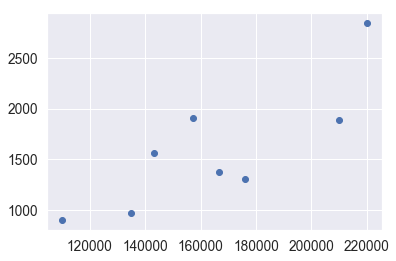

In [39]:
# See if there is a way to collapse neighborhoods
styles = [col for col in new_train.columns if "HouseStyle" in col]
style_agg = styles_df.groupby(styles).agg({"SalePrice":"mean","GrLivArea":"mean" }).reset_index()
x=style_agg["SalePrice"]
y=style_agg["GrLivArea"]
plt.scatter(x,y)

Nothing looks too out of the ordinary so I won't cut any of these variables

In [40]:
df = df.drop("Id", axis = 1)
df_test = df_test.drop("Id", axis = 1)

df = df.drop("TotalBsmtSF", axis = 1)
df_test = df_test.drop("TotalBsmtSF", axis = 1)

In [41]:
scaled_df, min_max_scaler_train = min_max_scaling(df, df.columns)
scaled_df_test = min_max_scaler_train.transform(df_test)

In [46]:
def feature_selection_xgboost(df, train_labels, iterations=10, threshold = .001):
    irrelevant_cols_total = []
    new_df = df
    
    for x in range(0,iterations):
        x = df.values
        y = train_labels.values
        y_log = np.log(y.reshape(-1,1))

        kf = KFold(n_splits=5, shuffle=True)
        
        rmse_sum = 0
        for train, test in kf.split(x):
            # Use index to create train and test data and labels
            train_data, train_label, test_data, test_label = x[train], y_log[train], x[test], y_log[test]

            xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                                   colsample_bytree=1, max_depth=7)
            xgb.fit(train_data,train_label)

            predictions = xgb.predict(test_data)
            print("The Root Mean Squared Error for this run is: %s" %rmse(test_label.reshape(test_label.shape[0],),
                                                                          predictions))
            rmse_sum +=rmse(test_label.reshape(test_label.shape[0],),predictions)
        print("Total rmse for these runs is %s" % rmse_sum)
        irrelevant_cols = df.columns[xgb.feature_importances_< threshold]
        irrelevant_cols_total += list(irrelevant_cols)
        df = df.drop(irrelevant_cols, axis = 1)
        print(df.shape)
    return df,irrelevant_cols_total

In [47]:
subset_df, dropped_cols = feature_selection_xgboost(df,train_labels)

The Root Mean Squared Error for this run is: 0.14249866929854005
The Root Mean Squared Error for this run is: 0.11940329724157399
The Root Mean Squared Error for this run is: 0.1168985989569145
The Root Mean Squared Error for this run is: 0.1391530196142997
The Root Mean Squared Error for this run is: 0.14545061114108196
Total rmse for these runs is 0.6634041962524102
(1460, 161)
The Root Mean Squared Error for this run is: 0.1398665947325717
The Root Mean Squared Error for this run is: 0.1264178025535863
The Root Mean Squared Error for this run is: 0.15342315788568914
The Root Mean Squared Error for this run is: 0.11240682978839293
The Root Mean Squared Error for this run is: 0.14355167286393372
Total rmse for these runs is 0.6756660578241738
(1460, 136)
The Root Mean Squared Error for this run is: 0.12450990328401038
The Root Mean Squared Error for this run is: 0.154946785747139
The Root Mean Squared Error for this run is: 0.12898191333134226
The Root Mean Squared Error for this run 

In [48]:
x = subset_df.values
x_test = df_test.drop(dropped_cols,axis=1).values
y = train_labels.values
y_log = np.log(y.reshape(-1,1))

xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(x,y_log)


predictions = xgb.predict(x_test)

In [49]:
predictions = np.exp(predictions)

In [62]:
test_df['Id']
submission = pd.DataFrame({'Id':test_df['Id']})
submission['SalePrice'] = np.round(predictions,2)
submission.head()
filename = 'submission_xgboost.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: submission_xgboost.csv


1880

Your Best Entry 

You advanced 2,505 places on the leaderboard!

Your submission scored 0.13369, which is an improvement of your previous score of 0.67275. Great job!

^^ (Score of .67275 has to have been a submission error on my part, I refuse to believe my first try was that bad)

In [50]:
def data_clean_part2(df):
    df['BsmtFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
    df = df.drop(['BsmtFinSF1','BsmtFinSF2'], axis = 1)
    df['outdoor_seating'] = df['WoodDeckSF']+df['OpenPorchSF']+df['EnclosedPorch'] + \
                        df['3SsnPorch']+ df['ScreenPorch']

    df = df.drop(['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'], axis=1)
    df["lot_shape"] = df['LotShape_IR1']+2*df['LotShape_IR2']+3*df['LotShape_IR3']
    df = df.drop(['LotShape_IR1','LotShape_IR2','LotShape_IR3','LotShape_Reg','LotShape_nan'], axis=1)
    df['utilities_score'] = 2*df['Utilities_AllPub']+df['Utilities_NoSeWa']
    df = df.drop(['Utilities_AllPub','Utilities_NoSeWa'], axis = 1)
    df['Condition1_Artery'] = df.apply(lambda x: 1 if x['Condition1_Artery']+x['Condition2_Artery'] >=1 else 0, axis=1)
    df['Condition1_Feedr'] = df.apply(lambda x: 1 if x['Condition1_Feedr']+x['Condition2_Feedr'] >=1 else 0, axis=1)
    df['Condition1_Norm'] = df.apply(lambda x: 1 if x['Condition1_Norm']+x['Condition2_Norm'] >=1 else 0, axis =1 )
    df['Condition1_PosA'] = df.apply(lambda x: 1 if x['Condition1_PosA']+x['Condition2_PosA'] >=1 else 0, axis =1 )
    df['Condition1_PosN'] = df.apply(lambda x: 1 if x['Condition1_PosN']+x['Condition2_PosN'] >=1 else 0, axis =1 )
    df['Condition1_RRAe'] = df.apply(lambda x: 1 if x['Condition1_RRAe']+x['Condition2_RRAe'] >=1 else 0, axis=1)
    df['Condition1_RRAn'] = df.apply(lambda x: 1 if x['Condition1_RRAn']+x['Condition2_RRAn'] >=1 else 0, axis=1)
    df['Condition1_RRNe'] = df['Condition1_RRNe'] # +df['Condition2_RRNe']  No instances of this
    df['Condition1_RRNn'] = df.apply(lambda x: 1 if x['Condition1_RRNn']+x['Condition2_RRNn'] >=1 else 0, axis=1)

    df = df.drop(['Condition1_nan','Condition2_nan','Condition2_Artery','Condition2_Feedr','Condition2_Norm',
                  'Condition2_PosA','Condition2_PosN','Condition2_RRAe','Condition2_RRAn','Condition2_RRNn'], axis =1)
    df['Exterior1st_AsbShng'] = df.apply(lambda x: 1 if x['Exterior1st_AsbShng'] + x['Exterior2nd_AsbShng'] >=1 else 0, axis =1)
    df['Exterior1st_AsphShn'] = df.apply(lambda x: 1 if x['Exterior1st_AsphShn'] + x['Exterior2nd_AsphShn'] >=1 else 0, axis =1)
    df['Exterior1st_BrkComm'] = df.apply(lambda x: 1 if x['Exterior1st_BrkComm'] + x['Exterior2nd_Brk Cmn'] >=1 else 0, axis =1)
    df['Exterior1st_BrkFace'] = df.apply(lambda x: 1 if x['Exterior1st_BrkFace'] + x['Exterior2nd_BrkFace'] >=1 else 0, axis =1)
    df['Exterior1st_CBlock'] = df.apply(lambda x: 1 if x['Exterior1st_CBlock'] + x['Exterior2nd_CBlock'] >= 1 else 0, axis =1)
    df['Exterior1st_CemntBd'] = df.apply(lambda x: 1 if x['Exterior1st_CemntBd'] + x['Exterior2nd_CmentBd'] >=1 else 0, axis =1)
    df['Exterior1st_HdBoard'] = df.apply(lambda x: 1 if x['Exterior1st_HdBoard'] + x['Exterior2nd_HdBoard'] >=1 else 0, axis =1)
    df['Exterior1st_ImStucc'] = df.apply(lambda x: 1 if x['Exterior1st_ImStucc'] + x['Exterior2nd_ImStucc'] >=1 else 0, axis =1)
    df['Exterior1st_MetalSd'] = df.apply(lambda x: 1 if x['Exterior1st_MetalSd'] + x['Exterior2nd_MetalSd'] >=1 else 0, axis =1)
    df['Exterior1st_Plywood'] = df.apply(lambda x: 1 if x['Exterior1st_Plywood'] + x['Exterior2nd_Plywood'] >=1 else 0, axis =1)
    df['Exterior1st_Stone'] = df.apply(lambda x: 1 if x['Exterior1st_Stone'] + x['Exterior2nd_Stone'] >=1 else 0, axis =1)
    df['Exterior1st_Stucco'] = df.apply(lambda x: 1 if x['Exterior1st_Stucco'] + x['Exterior2nd_Stucco'] >=1 else 0, axis =1)
    df['Exterior1st_VinylSd'] = df.apply(lambda x: 1 if x['Exterior1st_VinylSd'] + x['Exterior2nd_VinylSd'] >=1 else 0, axis =1)
    df['Exterior1st_Wd Sdng'] = df.apply(lambda x: 1 if x['Exterior1st_Wd Sdng'] + x['Exterior2nd_Wd Sdng'] >=1 else 0, axis =1)
    df['Exterior1st_WdShing'] = df.apply(lambda x: 1 if x['Exterior1st_WdShing'] + x['Exterior2nd_Wd Shng'] >=1 else 0, axis =1)

    df = df.drop(['Exterior1st_nan','Exterior2nd_nan','Exterior2nd_AsbShng','Exterior2nd_AsphShn','Exterior2nd_Brk Cmn',
            'Exterior2nd_BrkFace','Exterior2nd_CBlock','Exterior2nd_CmentBd','Exterior2nd_HdBoard','Exterior2nd_ImStucc',
            'Exterior2nd_MetalSd','Exterior2nd_Plywood','Exterior2nd_Stone','Exterior2nd_Stucco','Exterior2nd_VinylSd',
            'Exterior2nd_Wd Sdng','Exterior2nd_Wd Shng'], axis = 1)
    df['ExterQual_combined'] = 2*df['ExterQual_Ex']+df['ExterQual_Gd']-df['ExterQual_Fa']
    df['ExterCond_combined'] = 2*df['ExterCond_Ex']+df['ExterCond_Gd']-df['ExterCond_Fa']-2*df['ExterCond_Po']

    df = df.drop(['ExterQual_Ex','ExterQual_Fa','ExterQual_Gd','ExterQual_TA','ExterQual_nan'], axis = 1)
    df = df.drop(['ExterCond_Ex','ExterCond_Fa','ExterCond_Gd','ExterCond_TA','ExterCond_Po','ExterCond_nan'], axis = 1)
    df['BsmtQual_combined'] = 2*df['BsmtQual_Ex']+df['BsmtQual_Gd']-df['BsmtQual_Fa']
    df = df.drop(['BsmtQual_Ex','BsmtQual_Fa','BsmtQual_Gd','BsmtQual_TA','BsmtQual_nan'], axis = 1)
    df['HeatingQC_combined'] = 2*df['HeatingQC_Ex']+df['HeatingQC_Gd']-df['HeatingQC_Fa']-2*df['HeatingQC_Po']
    df = df.drop(['HeatingQC_Ex','HeatingQC_Fa','HeatingQC_Gd','HeatingQC_TA','HeatingQC_Po','HeatingQC_nan'], axis = 1)
    df = df.drop(['CentralAir_N', 'CentralAir_nan'], axis =1)
    df['KitchenQual_combined'] = 2*df['KitchenQual_Ex']+df['KitchenQual_Gd']-df['KitchenQual_Fa']
    df = df.drop(['KitchenQual_Ex','KitchenQual_Fa','KitchenQual_Gd','KitchenQual_TA','KitchenQual_nan'], axis = 1)
    df = df.drop(['MoSold_nan','YrSold_nan'], axis =1)
    df['sold_winter'] = df['MoSold_12.0']+df['MoSold_1.0']+df['MoSold_2.0']
    df['sold_spring'] = df['MoSold_3.0']+df['MoSold_4.0']+df['MoSold_5.0']
    df['sold_summer'] = df['MoSold_6.0']+df['MoSold_7.0']+df['MoSold_8.0']
    df['sold_fall'] = df['MoSold_9.0']+df['MoSold_10.0']+df['MoSold_11.0']

    df = df.drop(['MoSold_1.0','MoSold_2.0','MoSold_3.0','MoSold_4.0','MoSold_5.0','MoSold_6.0',
                 'MoSold_7.0','MoSold_8.0','MoSold_9.0','MoSold_10.0','MoSold_11.0','MoSold_12.0'], axis=1)
    df['BsmtCond_combined'] = df['BsmtCond_Gd']-df['BsmtCond_Fa']-2*df['BsmtCond_Po']
    df = df.drop(['BsmtCond_Fa','BsmtCond_Gd','BsmtCond_TA','BsmtCond_Po'], axis = 1)
    df['GarageQual_combined'] = 2*df['GarageQual_Ex']+df['GarageQual_Gd']-df['GarageQual_Fa']-2*df['GarageQual_Po']
    df['GarageCond_combined'] = 2*df['GarageCond_Ex']+df['GarageCond_Gd']-df['GarageCond_Fa']-2*df['GarageCond_Po']

    df = df.drop(['GarageQual_Ex','GarageQual_Fa','GarageQual_Gd','GarageQual_TA','GarageQual_Po'], axis = 1)
    df = df.drop(['GarageCond_Ex','GarageCond_Fa','GarageCond_Gd','GarageCond_TA','GarageCond_Po'], axis = 1)
    df['FireplaceQu_combined'] = 2*df['FireplaceQu_Ex']+df['FireplaceQu_Gd']-df['FireplaceQu_Fa']-2*df['FireplaceQu_Po']
    df = df.drop(['FireplaceQu_Ex','FireplaceQu_Fa','FireplaceQu_Gd','FireplaceQu_TA','FireplaceQu_Po'], axis = 1)
    return df

In [51]:
clean_df = data_clean_part2(df)
clean_df_test = data_clean_part2(df_test)

In [52]:
subset_df, dropped_cols = feature_selection_xgboost(clean_df,train_labels)

The Root Mean Squared Error for this run is: 0.1258554708995302
The Root Mean Squared Error for this run is: 0.11405472947029886
The Root Mean Squared Error for this run is: 0.12998423095989922
The Root Mean Squared Error for this run is: 0.17089147628688164
The Root Mean Squared Error for this run is: 0.14742278384526583
Total rmse for these runs is 0.6882086914618758
(1460, 133)
The Root Mean Squared Error for this run is: 0.13847669877623753
The Root Mean Squared Error for this run is: 0.11612828531501439
The Root Mean Squared Error for this run is: 0.125604337838161
The Root Mean Squared Error for this run is: 0.11209180923506236
The Root Mean Squared Error for this run is: 0.14159611630848362
Total rmse for these runs is 0.633897247472959
(1460, 114)
The Root Mean Squared Error for this run is: 0.13131715915878522
The Root Mean Squared Error for this run is: 0.14233548538024382
The Root Mean Squared Error for this run is: 0.1347459786779016
The Root Mean Squared Error for this run

In [838]:
# Find optimal hyperparameters using new dataset and forest size of 100; will then 
# train final model using these hyperparameters but with a larger number of trees
# Set the parameters by cross-validation

# Note: ran multiple times, narrowing the parameters at each point.  When the "middle" option
# for a given parameter was chosen twice in a row, I settled on that and made it the only option moving forward
x = clean_df.values
y = train_labels.values
y_log = np.log(y.reshape(-1,1))


parameters = [{'learning_rate': [.12],
               'gamma': [2.5e-3],
                'subsample': [.70],
               'max_depth': [6], 
               'colsample_bytree': [.6]}]

print("# Tuning hyper-parameters")
print()

model = GridSearchCV(xgboost.XGBRegressor(n_estimators=100), parameters, cv=5)
model.fit(x, y)

print("Best parameters set found on development set:")
print()
print(model.best_params_)
print()
print("Grid scores on training set:")
print()
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters

Best parameters set found on development set:

{'colsample_bytree': 0.6, 'gamma': 0.0025, 'learning_rate': 0.12, 'max_depth': 6, 'subsample': 0.7}

Grid scores on training set:

0.882 (+/-0.059) for {'colsample_bytree': 0.6, 'gamma': 0.0025, 'learning_rate': 0.12, 'max_depth': 6, 'subsample': 0.7}
0.873 (+/-0.070) for {'colsample_bytree': 0.7, 'gamma': 0.0025, 'learning_rate': 0.12, 'max_depth': 6, 'subsample': 0.7}



In [835]:
x = clean_df.values
x_test = clean_df_test.values
y = train_labels.values
y_log = np.log(y.reshape(-1,1))

xgb = xgboost.XGBRegressor(n_estimators=10000, learning_rate=0.12, gamma=0.0025, subsample=0.7,
                           colsample_bytree=.6, max_depth=6)
xgb.fit(x,y_log)


predictions = xgb.predict(x_test)
predictions = np.exp(predictions)

In [836]:
test_df['Id']
submission = pd.DataFrame({'Id':test_df['Id']})
submission['SalePrice'] = np.round(predictions,2)
submission.head()
filename = 'submission_xgboost_tuned_10000trees_allvars.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: submission_xgboost_tuned_10000trees_allvars.csv


1696

Your Best Entry 

You advanced 210 places on the leaderboard!

Your submission scored 0.13031, which is an improvement of your previous score of 0.13369. Great job!

In [69]:
import sklearn.neural_network as neural_network

scaled_df, min_max_scaler_train = min_max_scaling(clean_df, clean_df.columns)

x = scaled_df.values
y = train_labels.values
y_log = np.log(y.reshape(-1,1))

# Do K-folds to create train/test splits
kf = KFold(n_splits=5, shuffle=True, random_state=1)

for train, test in kf.split(x):
    # Use index to create train and test data and labels
    train_data, train_label, test_data, test_label = x[train], y_log[train], x[test], y_log[test]

    mlp = neural_network.MLPRegressor(hidden_layer_sizes=(268,268*2,268,120,60))    
    mlp.fit(train_data,train_label)

    y_pred = mlp.predict(test_data)
    print("The Root Mean Squared Error for this run is: %s" %rmse(test_label.reshape(test_label.shape[0],),
                                                                              y_pred))



The Root Mean Squared Error for this run is: 0.21064575420645537
The Root Mean Squared Error for this run is: 0.21415055491106527
The Root Mean Squared Error for this run is: 0.1788241800062292
The Root Mean Squared Error for this run is: 0.22138502422548026
The Root Mean Squared Error for this run is: 0.1759977260517739


1) Opening slide
2) Overview of the problem 
    What are we trying to predict?
    What variables are in play?
    What did we think would happen prior to writing code?
3) Data cleanup
4) Model 1, outcome 1| model x, outcome x
5) Future steps (if we had more time....)